# Image classification from scratch 从零开始的图像分类

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2022/11/10<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset. 在 Kaggle Cats vs Dogs 数据集上从头开始训练图像分类器。

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
classification dataset.
这个例子展示了如何从头开始进行图像分类，从 JPEG 开始
磁盘上的图像文件，无需利用预训练的权重或预制的 Keras
应用模型。我们在 Kaggle Cats vs Dogs 二进制文件上演示了工作流程
分类数据集。

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.
我们使用 `image_dataset_from_directory` 工具来生成数据集，并且
我们使用 Keras 图像预处理层进行图像标准化和数据增强。

## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-04-11 12:58:55.064527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [1]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  5441k      0  0:02:28  0:02:28 --:--:-- 5349k


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 01-image_classification_from_scratch.ipynb   PetImages
 CDLA-Permissive-2.0.pdf		     'readme[1].txt'
 kagglecatsanddogs_5340.zip


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.

In [5]:
!ls PetImages

Cat  Dog


### Filter out corrupted images
过滤掉损坏的图像

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.
在处理大量真实世界的图像数据时，损坏的图像很常见。 让我们过滤掉标头中没有字符串“JFIF”的编码错误的图像。

In [3]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


## Generate a `Dataset`

In [4]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


2023-04-11 12:59:14.367724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


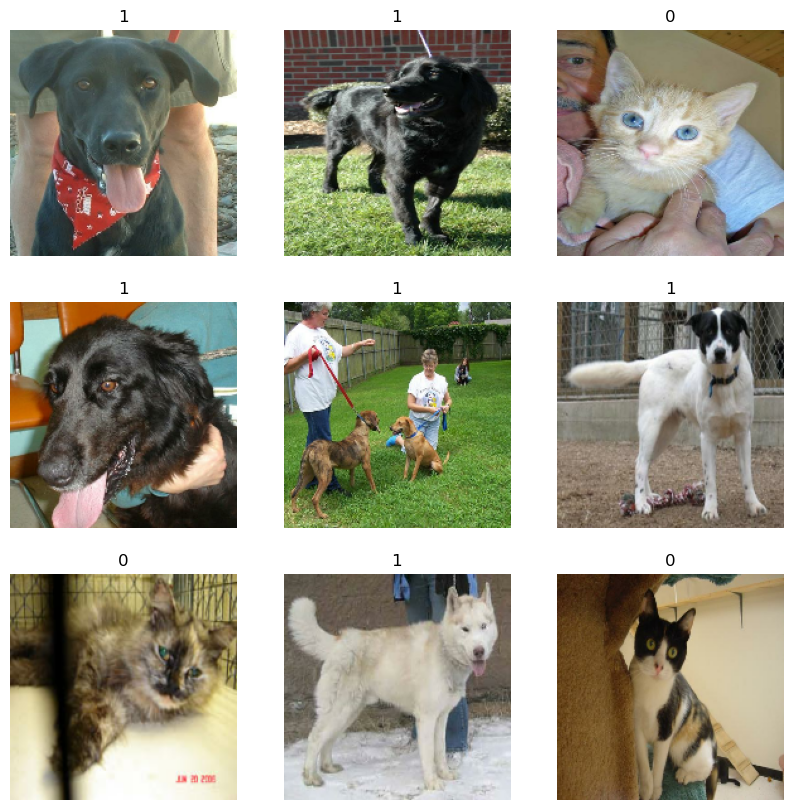

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation
使用图像数据增强

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.
当您没有大型图像数据集时，通过对训练图像应用随机但逼真的变换（例如随机水平翻转或小的随机旋转）来人为引入样本多样性是一种很好的做法。
这有助于将模型暴露于训练数据的不同方面，同时减缓过度拟合。

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


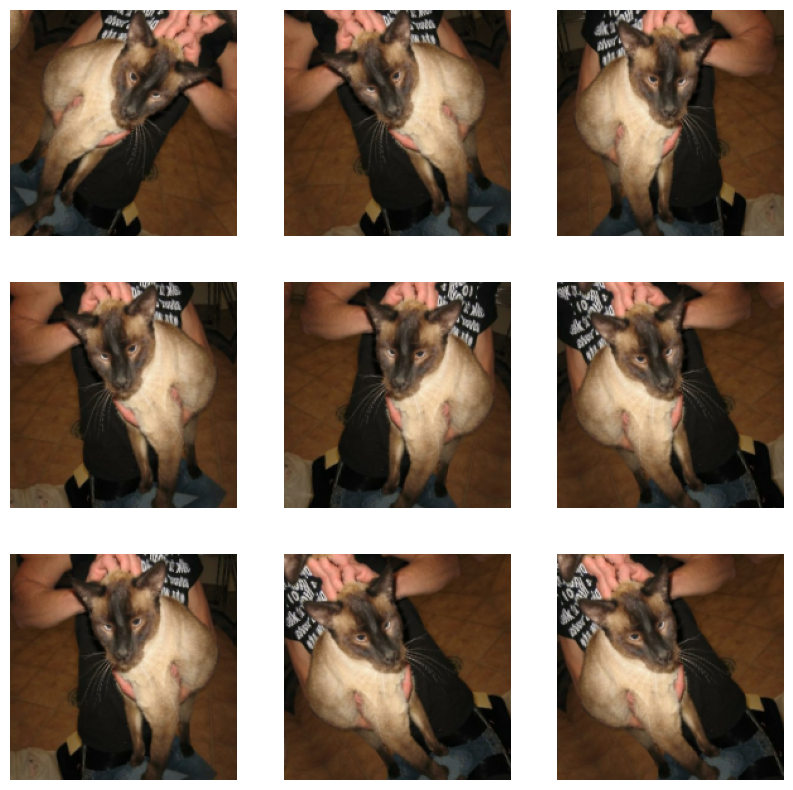

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data
标准化数据

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.
我们的图像已经是标准尺寸 (180x180)，因为它们被生成为
我们数据集的连续“float32”批次。 但是，它们的 RGB 通道值在
`[0, 255]` 范围。 这对于神经网络来说并不理想；
一般来说，您应该设法使您的输入值变小。 在这里，我们将
通过在我们的模型。

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [9]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

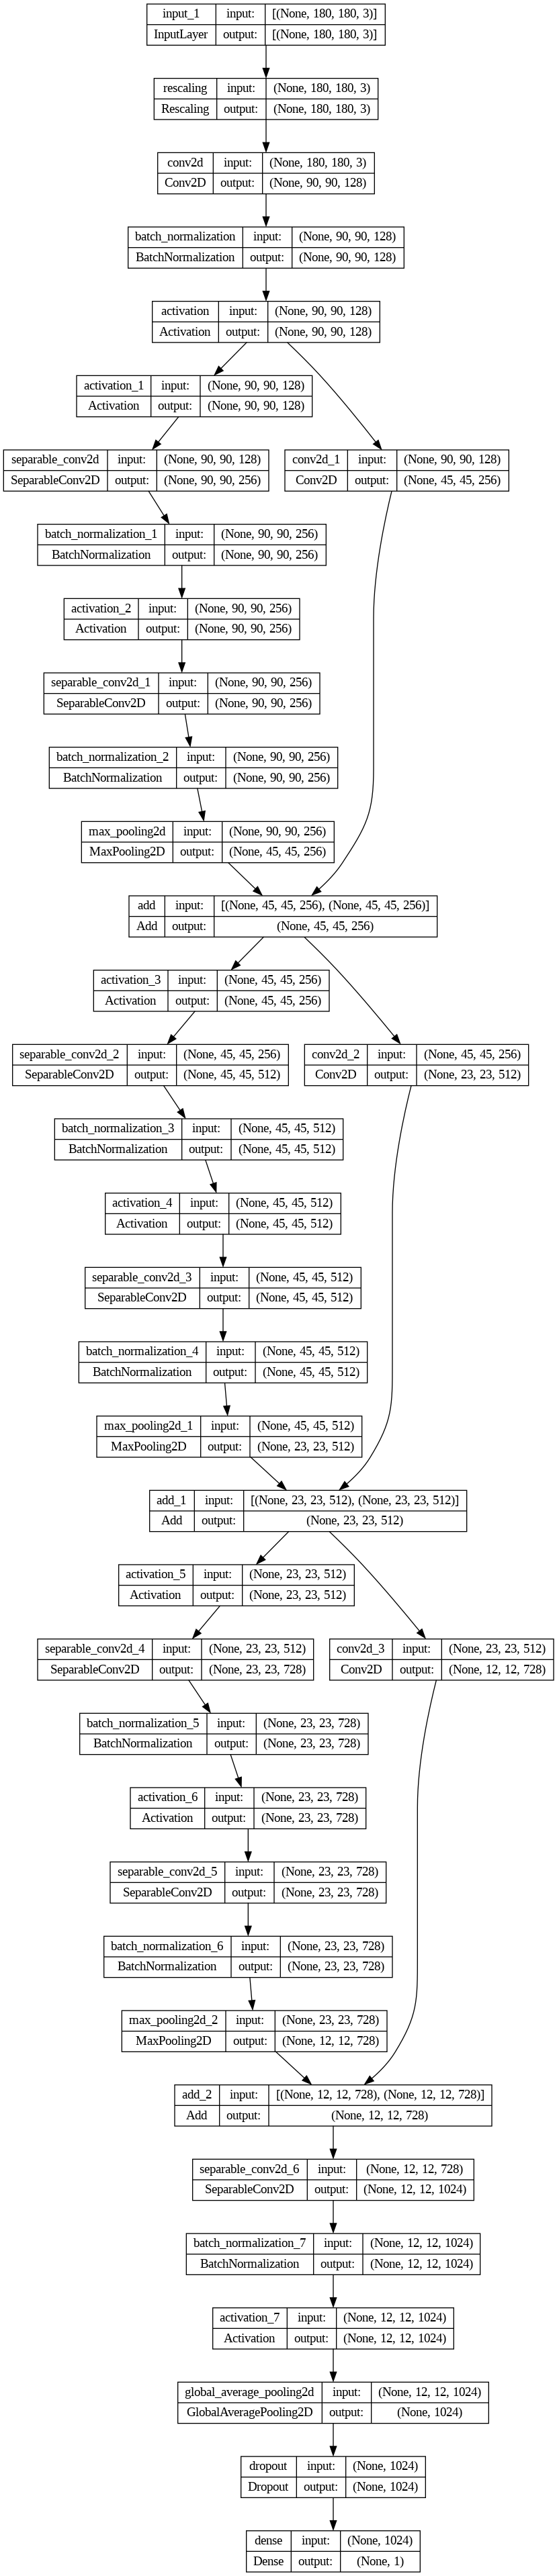

In [10]:

def make_model(input_shape, num_classes):
    # print(input_shape) # (180, 180, 3)
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2023-04-11 12:51:28.637968: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 530841600 exceeds 10% of free system memory.
2023-04-11 12:51:29.669715: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 530841600 exceeds 10% of free system memory.
2023-04-11 12:51:30.862769: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 530841600 exceeds 10% of free system memory.
2023-04-11 12:51:31.984184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 530841600 exceeds 10% of free system memory.
2023-04-11 12:51:32.643753: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1061683200 exceeds 10% of free system memory.


 17/147 [==>...........................] - ETA: 42:56 - loss: 0.7536 - accuracy: 0.5584

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [7]:
print()
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
print(img_array.shape)
print(img_array)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

(180, 180, 3)
[[[249. 254. 247.]
  [249. 255. 251.]
  [252. 253. 255.]
  ...
  [251. 253. 250.]
  [253. 253. 251.]
  [253. 253. 251.]]

 [[253. 252. 250.]
  [252. 254. 251.]
  [249. 255. 253.]
  ...
  [252. 252. 250.]
  [254. 254. 252.]
  [254. 254. 252.]]

 [[253. 251. 252.]
  [253. 253. 251.]
  [249. 255. 251.]
  ...
  [253. 253. 251.]
  [254. 254. 252.]
  [254. 254. 252.]]

 ...

 [[252. 254. 251.]
  [253. 253. 251.]
  [253. 253. 251.]
  ...
  [253. 253. 251.]
  [254. 254. 252.]
  [254. 254. 252.]]

 [[252. 254. 249.]
  [253. 254. 249.]
  [253. 253. 251.]
  ...
  [253. 253. 251.]
  [254. 254. 252.]
  [254. 254. 252.]]

 [[252. 254. 249.]
  [253. 254. 249.]
  [253. 253. 251.]
  ...
  [253. 253. 251.]
  [254. 254. 252.]
  [254. 254. 252.]]]


NameError: name 'model' is not defined